# 1η Εργασία Νευρωνικά Δίκτυα
Μέρος 2

Μέλη

Γιωργουλάκης Νικόλαος: 03117138

Μπεκρής Δημήτρης: 03117116

Χλαπάνης Οδυσσέας: 03117023

## Εισαγωγή και Επισκόπηση

Εισαγωγή βιβλιοθηκών

In [ ]:
#Basic
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#splits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
#transformations
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#classifiers
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
#optimization
from sklearn.pipeline import make_pipeline
import optuna
#utils
import time 
import random
import pickle
import os

### Περιγραφή δεδομένων

Το [σύνολο δεδομένων](https://www.kaggle.com/muhakabartay/sloan-digital-sky-survey-dr16) που εξετάσαμε είναι το Sloan Digital Sky Survey DR16. Αποτελεί μία μελέτη τριών διαφορετικών ουράνιων σωμάτων: γαλαξιών, αστέρων και κβάζαρ. Τα δεδομένα προκύπτουν από δύο κατηγορίες, από μία μεγάλη βάση δεδομένων. Η μία κατηγορία είναι τα φωτομετρικά δεδομένα και η άλλη τα φασματικά δεδομένα. Το ζητούμενο του προβλήματος είναι να αποφανθούμε για κάθε δείγμα την κατηγορία του.

Ο φακός που έχει χρησιμοποιηθεί για την λήψη των δεδομένων είναι της τεχνολογίας CCD array και έχει πέντε διαφορετικά κανάλια, τα u, g, r, i, z, τα οποία αποτελούν σημαντικά χαρακτηριστικά για την ταξινόμηση των δειγμάτων. Οι στήλες ra και dec είναι επιπλέον δεδομένα για το κανάλι r. 

Το πιο σημαντικό χαρακτηριστικό είναι το redshift, δηλαδή η μετατόπιση προς το ερυθρό. Ο λόγος είναι ότι με βάση το φαινόμενο Doppler, η μετατόπιση προς το ερυθρό αποτελεί καλό μέτρο της απόστασης ενός ουράνιου σώματος από το τηλεσκόπιο που το φωτογραφίζει. Επειδή τα διαφορετικά είδη σωμάτων βρίσκονται κατά μέσο όρο σε πολύ διαφορετική κλίμακα αποστάσεων αυτό είναι σημαντικό (βλέπε διάγραμμα παρακάτω και για περισσότερα Παράρτημα).

Όλα τα υπόλοιπα χαρακτηριστικά θα τα απορρίψουμε (βλέπε διάγραμμα στο Παράρτημα). Τα χαρακτηριστικά 'run', 'rerun', 'camcol' και 'field' αφορούν το πεδίο λήψης της εικόνας (field). Όπως θα εξηγήσουμε παρακάτω και στο Παράρτημα, δεν θα τα χρησιμοποιήσουμε. Υπάρχουν και χαρακτηριστικά που είναι παραπροϊόντα της αναζήτησης (query) στη βάση δεδομένων (objid, fiberid, specobjid). Τέλος, το χαρακτηριστικό mjd είναι η Modified Julian Date ([περισσότερα εδώ](https://core2.gsfc.nasa.gov/time/))που χρησιμοποιείται στην αστρονομία για την καταγραφή της ημερομηνίας των μετρήσεων. Η χρήση της ημερομηνίας σαν χαρακτηριστικό θα μπορούσε να δημιουργήσει "τεχνητές" συσχετίσεις με την διαδικασία της φωτογράφισης, και όχι με τα ίδια τα σώματα, όπως και τα υπόλοιπα χαρακτηριστικά που αφορούν τις συνθήκες λήψης.

### Εισαγωγή δεδομένων

Εισάγουμε τα δεδομένα σε μορφή csv, σαν αντικείμενο dataframe με την βιβλιοθήκη pandas. Αφαιρούμε από τα δεδομένα τις στήλες των **χαρακτηριστικών λήψης τα οποία δεν αφορούν την ταξινόμηση των ουράνιων σωμάτων**, όπως εξηγούμε στο Παράρτημα. Τα διανύσματα X και y περιέχουν όλα τα δεδομένα και τις ετικέτες αντίστοιχα. Τα χωρίζουμε σε train και test με ποσοστό 70-30. 

In [ ]:
data_df = pd.read_csv("../input/sloan-digital-sky-survey-dr16/Skyserver_12_30_2019 4_49_58 PM.csv")
y = data_df['class'].to_numpy()
data_df2 = data_df.drop(['run', 'rerun', 'camcol', 'field', 'objid', 'specobjid', 'fiberid', 'plate', 'mjd'], axis = 1)
data_df2.drop('class', axis = 1, inplace= True)
X = data_df2.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
data_df.head(1)

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237666301628060000,47.372545,0.820621,18.69254,17.13867,16.55555,16.34662,16.17639,4849,301,5,771,8168632633242440000,STAR,0.000115,7255,56597,832


### Μετρικές

Θα χρησιμοποιήσουμε δύο μετρικές, το accuracy και το F1-macro. Το accuracy είναι η πιο σκληρή μετρική, ενώ το F1 θα δώσει ένα πιο αντιπροσωπευτικό αποτέλεσμα επειδή, όπως θα δούμε, το σύνολο δεδομένων είναι μη-ισορροπημένο. Επειδή θέλουμε να δοκιμάσουμε και τεχνικές εξισορρόπησης και θέλουμε να έχουμε και μία γενική εικόνα με όλα τα δεδομένα μας θα χρησιμοποιήσουμε και τα δύο.

### Train-test split και σχήμα Cross Validation

Όπως είπαμε, χωρίσαμε το σύνολο των δεδομένων σε train και test. Η τελική αξιολόγηση για όλους τους ταξινομητές γίνεται στο accuracy και το f1-macro score στο test set.

Για να επισπεύσουμε την πειραματική διαδικασία, ειδικά για το κομμάτι της βελτιστοποίησης, σε κάποιες περιπτώσεις χρειαστήκαμε ένα μικρό τμήμα του συνόλου δεδομένων εκπαίδευσης (train) για το fit. Αντί να κόψουμε (slice) αυθαίρετα τα δεδομένα μας, ορίσαμε ένα βοηθητικό σετ δεδομένων με τη βοήθεια της συνάρτησης: StratifiedShuffleSplit.

Το σύνολο δεδομένων, μετά την απαραίτητη προεπεξεργασία που αναφέραμε, έχει πλήθος δειγμάτων 70.000 και πλήθος χαρακτηριστικών 8. Είναι πρόβλημα πολλαπλών κλάσεων (αστέρι, γαλαξίας, κβάζαρ). Τα χαρακτηριστικά που θα χρησιμοποιήσουμε για την ταξινόμηση των ουράνιων σωμάτων αφορούν αποκλειστικά τις φυσικές τους ιδιότητες όπως τις παρατηρούν οι αστρονόμοι από το τηλεσκόπιο με τη χρήση των ειδικών αισθητήρων. Περισσότερες πληροφορίες για τα χαρακτηριστικά των δειγμάτων στο Παράρτημα. Σημειώνουμε ότι δεν κρίνεται αναγκαία άλλη προεπεξεργασία καθώς δεν υπάρχουν απουσιάζουσες τιμές και όλα τα χαρακτηριστικά είναι διατεταγμένα (floats και ints).

In [ ]:
print(X_train.shape)
print(np.unique(y_train))

(70000, 8)
['GALAXY' 'QSO' 'STAR']


### Ισορροπία συνόλου δεδομένων

Όπως φαίνεται παρακάτω το dataset είναι αρκετά imbalanced προς την μεριά της κλάσης Galaxy η οποία αποτελεί πάνω από τα μισά δείγματα εκπαίδευσης (η κλάση Quasars αποτελεί μόνο το 10% των δειγμάτων).

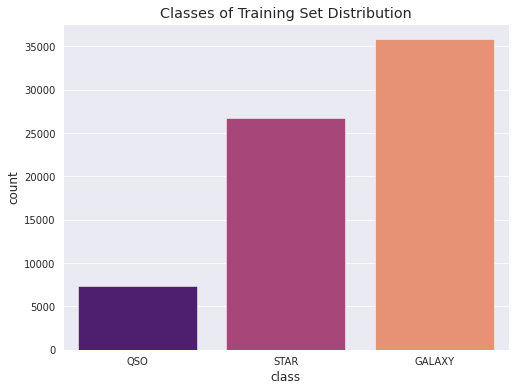

In [ ]:
labels = pd.DataFrame(y_train, columns=['class'])
sns.set_style('darkgrid')
plt.figure(figsize = (8, 6))
sns.countplot(x=labels['class'], palette = 'magma')
plt.title("Classes of Training Set Distribution")
plt.show()

### Μελέτη κατανομής χαρακτηριστικών-κλάσεων

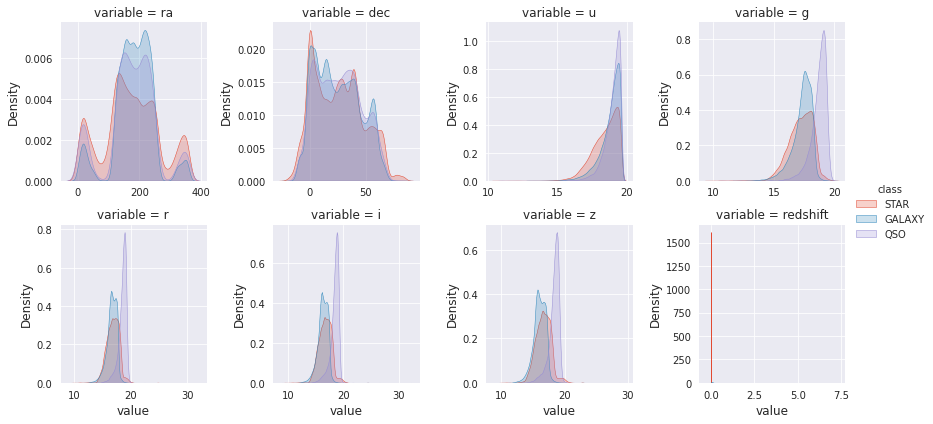

In [ ]:
melted = data_df.melt(id_vars = ['class'], value_vars=['ra','dec','u','g','r','i','z','redshift'])
g = sns.FacetGrid(melted, col='variable', col_wrap=4, hue = 'class',
                 margin_titles=True, sharex=False, sharey=False)
g = g.map(sns.kdeplot, 'value', shade=True)
g = g.add_legend()

Το χαρακτηριστικό μετατόπισης προς το ερυθρό (redshift) διαχωρίζει τόσο καλά τα δεδομένα που είναι σε τελείως **διαφορετική κλίμακα** με αποτέλεσμα να μην φαίνονται καν στην γραφική παράσταση (αυτό είναι πολύ θετικό επειδή σημαίνει ότι θα είναι εύκολα διαχωρίσιμα). Αυτό ερμηνεύεται εύκολα μέσω του φαινομένου Doppler. Περισσότερα στο Παράρτημα.

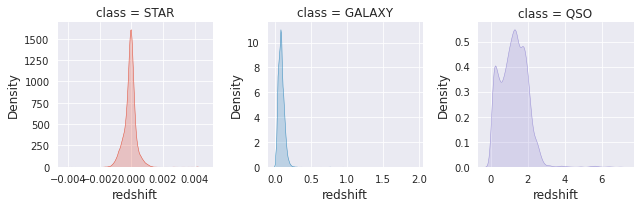

In [ ]:
g = sns.FacetGrid(data_df, col='class', hue='class', margin_titles=True, sharex=False, sharey=False)
g = g.map(sns.kdeplot, 'redshift', shade=True)

### Πίνακας συσχέτισης χαρακτηριστικών (Correlation Heatmap)

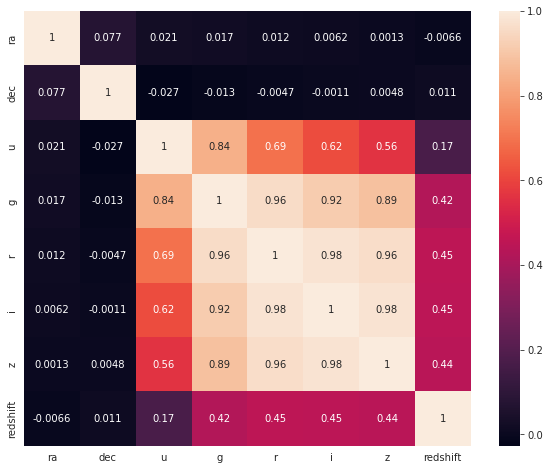

In [ ]:
corr = data_df2.corr()
plt.figure(figsize = (10, 8))
sns.heatmap(corr, annot = True)
plt.show()

Φαίνεται ότι τα χαρακτηριστικά των καναλιών u, g, r, i, z αλλά και του redshift είναι αρκετά συσχετισμένα. Ίσως μία PCA ανάλυση να βοηθούσε στην αποσυσχέτισή τους. Αυτό θα το δούμε αργότερα στην βελτιστοποίηση (feature extraction).

## Επίδοση out-of-the-box

In [ ]:
def out_box(clf, X, y, Xtest, ytest, timer=False):
    start = time.time()
    
    clf.fit(X,y)
    y_pred = clf.predict(Xtest)
    acc = clf.score(Xtest,ytest)
    f1 = f1_score(ytest, y_pred, average='macro')
    
    end = time.time()
    if timer:
        return acc, f1,  clf, y_pred, (end-start)
    else:
        return acc, f1,  clf, y_pred

### Dummy ταξινομητής

In [ ]:
dummy = DummyClassifier(strategy="most_frequent")
acc_df,f1_df, clf_df, y_df = out_box(dummy, X_train, y_train, X_test, y_test)
print('Dummy most frequent')
print(f'accuracy score: {acc_df:.3f}')
print(f'f1 macro score: {f1_df:.3f}')
dummy = DummyClassifier(strategy="stratified")
acc_ds,f1_ds, clf_ds, y_ds = out_box(dummy, X_train, y_train, X_test, y_test)
print('Dummy stratified')
print(f'accuracy score: {acc_ds:.3f}')
print(f'f1 macro score: {f1_ds:.3f}')

Dummy most frequent
accuracy score: 0.516
f1 macro score: 0.227
Dummy stratified
accuracy score: 0.422
f1 macro score: 0.331


### SVM ταξινομητής

In [ ]:
'''
svm = SVC()
acc,f1, _, _ = out_box(svm, X_train, y_train, X_test, y_test)
print(f'accuracy score: {acc:.3f}')
print(f'f1 macro score: {f1:.3f}')
'''
''

#### Παρατήρηση για τον SVM

Επειδή ο SVM είναι αρκετά ευαίσθητος
στις μεγάλες τιμές των χαρακτηριστικών και στις απότομες μεταβολές,
προτείνεται από την βιβλιοθήκη sklearn 
να χρησιμοποιείται σε σειρά με έναν 
μετασχηματισμό Standard Scaling,
όπως και στο παράδειγμα χρήσης στο documentation της
sklearn (δες [εδώ](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)).
Για αυτό το λόγο, και για θέματα αποτελεσμάτων, αλλά και για θέματα ευστάθειας, χρησιμοποιούμε
σε όλα τα πειράματα κάποιον μετασχηματισμό κανονικοποίησης.

In [ ]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
acc_s,f1_s, clf_s, y_s,  fit_time = out_box(svm, X_train, y_train, X_test, y_test, timer = True)
print(f'accuracy score: {acc_s:.3f}')
print(f'f1 macro score: {f1_s:.3f}')
print(f'Fit time: {fit_time:.1f} seconds')

accuracy score: 0.974
f1 macro score: 0.972
Fit time: 57.7 seconds


### MLP ταξινομητής

In [ ]:
mlp = MLPClassifier(max_iter = 300)
acc_m,f1_m,clf_m , y_m, fit_time = out_box(mlp, X_train, y_train, X_test, y_test, timer = True)
print(f'accuracy score: {acc_m:.3f}')
print(f'f1 macro score: {f1_m:.3f}')
print(f'Fit time: {fit_time:.1f} seconds')

accuracy score: 0.978
f1 macro score: 0.968
Fit time: 16.6 seconds


#### Custom MLP

Με τον ίδιο τρόπο τρέξαμε και ένα Custom MLP το οποίο το φτιάξαμε μόνοι μας. Περισσότερα στο Παράρτημα.

### Σύγκριση επιδόσεων out-of-the-box

| Classifier    | Acc |    F1|
|---------------|:-----:|-----------:|
| Dummy - most frequent|  0.512 |       0.226 |
| Dummy - stratified|  0.512 |       0.226 |
| SVM   |  0.975 |       0.973 |
| MLP   |  0.981 |       0.973 |

Confusion Matrix για out-of-the-box δοκιμές

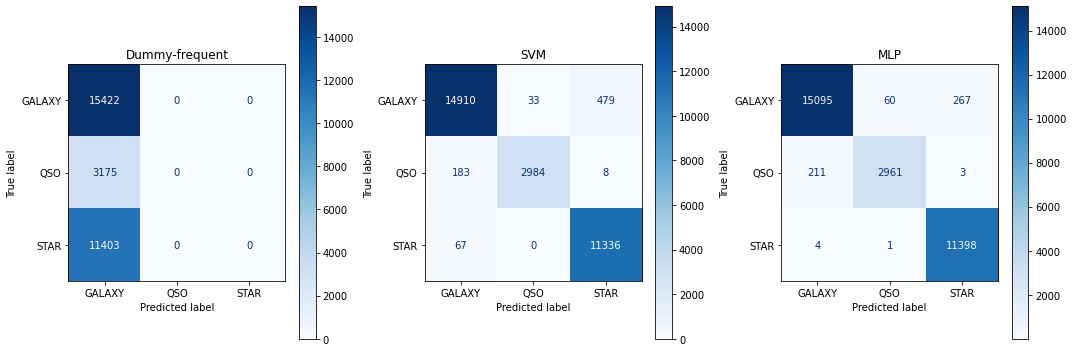

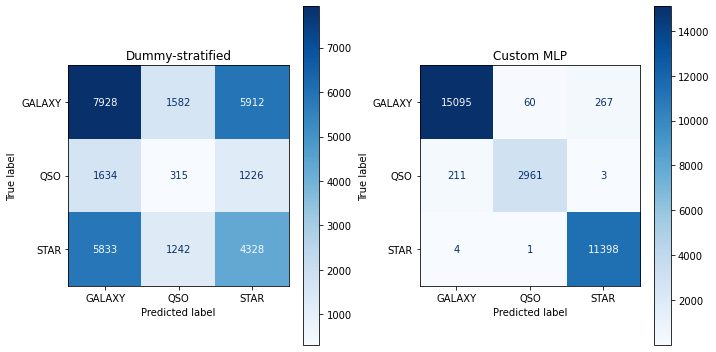

''

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
#predictions = [y_df, y_ds, y_s, y_m]
models = [clf_df, clf_s, clf_m]
clfs = ['Dummy-frequent', 'SVM','MLP']
#for y_pred, ax, clf in zip(predictions, axes.flatten(), clfs):
    #ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
for model, ax, clf in zip(models, axes.flatten(), clfs):
    plot_confusion_matrix(model, 
                              X_test, 
                              y_test, 
                              ax=ax, 
                              cmap='Blues')
    ax.title.set_text(clf)
    plt.tight_layout()  
plt.show()
'''
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
models = [clf_ds, clf_cm] 
clfs = ['Dummy-stratified', 'Custom MLP']
for model, ax, clf in zip(models, axes.flatten(), clfs):
    plot_confusion_matrix(model, 
                              X_test, 
                              y_test, 
                              ax=ax, 
                              cmap='Blues')
    ax.title.set_text(clf)
    plt.tight_layout()  
plt.show()
'''
''

Η παραπάνω φωτογραφία φαίνεται (διορθωμένη στον Custom MLP) και στον φάκελο images του παραδοτέου zip

#### Συμπεράσματα για την διαδικασία βελτιστοποίησης

Πρώτον βλέπουμε ότι ήδη οι ταξινομητές τα πηγαίνουν πολύ καλά, καθώς και στο accuracy και στο F1 έχουν παρόμοια αποτελέσματα, οπότε δεν μας επηρεάζει τόσο η επιλογή μετρικής. Από τη στιγμή που ήδη με τα out-of-the-box έχουμε επιδόσεις μεγαλύτερες του 0.97 είναι λογικό να περιμένουμε ότι θα πλησιάσουμε και ίσως ξεπεράσουμε το 0.99 μετά την διαδικασία βελτιστοποίησης.

## Βελτιστοποίηση

Σημείωση για την παρουσιάση των αποτελεσμάτων:

Όπως συζητήθηκε και στο help-desk αλλά και στον server του μαθήματος στο discord, κάποια πειράματα τα τρέξαμε ανεξάρτητα στο Google Colab, και έτσι τα παρουσιάζουμε εδώ σε markdown με τα αποτελέσματά τους και τον κώδικα σε κείμενο. Τα αποτελέσματα του Colab τα αποθηκεύσαμε σε μορφή pickle, την οποία έχουμε επισυνάψει στο παραδοτέο, και την διαβάζουμε για να πάρουμε το αντικείμενο Study της optuna. 

#### Επιλογή μικρού μέρους του συνόλου δεδομένων για μερική βελτιστοποίηση επιμέρους ταξινομητών 

Όπως είπαμε και προηγουμένως, κάποια πειράματα τα κάνουμε στο βοηθητικό, μικρό σύνολο δεδομένων και τα συνολικά πειράματα τα κάνουμε στο κανονικό, πλήρες σύνολο εκπαίδευσης. Για το σκοπό αυτό αξιοποιούμε την συνάρτηση StratifiedShuffleSplit.

In [ ]:
ratio = 0.05
N = len(y_train)
N = int(N*ratio)
sss = StratifiedShuffleSplit(n_splits=10, test_size = N//2, train_size = N, random_state=0)
for train_index, test_index in sss.split(X_train, y_train):
    X_small, X_test_small = X[train_index], X[test_index]
    y_small, y_test_small = y[train_index], y[test_index]
    break

#### Συναρτήσεις βελτιστοποίησης της βιβλιοθήκης Optuna

Για τα πειράματα βελτιστοποίησης, χρησιμοποιούμε δύο ειδών συναρτήσεις της Optuna. Για τα πιο ευέλικτα πειράματα, στα οποία θέλουμε να δοκιμάσουμε πολλές διαφορετικές εκδοχές των παραμέτρων, ακόμα και διαφορετικούς ταξινομητές, χρησιμοποιούμε την γενική κλάση objective, όπως προτείνεται και από το documentation. Αντίθετα, για πιο μικρά και σύντομα πειράματα, στα οποία ενδεχωμένος βελτιστοποιούμε μόνο μία, κρίσιμη μεταβλητή, τότε χρησιμοποιούμε την συνάρτηση GridSearchCV της Optuna, η οποία είναι της ίδιας λογικής με την αντίστοιχη του sklearn.

Ακολουθήσαμε την εξής στρατηγική: πρώτα εκτελούμε κάποια χρονοβόρα πειράματα με όλες τις πιθανές επιλογές και στη συνέχεια περιορίζουμε τις επιλογές στις πιο σημαντικές από αυτές. Την στρατηγική αυτήν όμως δεν την ακολουθήσαμε αυστηρά. Επίσης, αυξομειώναμε συχνά και το ratio που καθορίζει το μεγέθους του dataset έτσι ώστε να διαρκέσουν τα πειράματα το χρόνο που είχαμε στη διάθεσή μας, αλλά και να πάρουμε όσο το δυνατόν πιο αξιόπιστα αποτελέσματα στο τέλος.

#### Βελτιστοποίηση Ταξινομητή SVM


Πείραμα SVM:

Για το πρώτο μεγάλο πείραμα στο SVM χρησιμοποιήσαμε την συνάρτηση objective της Optuna. Δοκιμάσαμε διάφορους μετασχηματισμούς () και διάφορες παραμέτρους του SVM για να δούμε τι βοηθάει και τι όχι. Ο κώδικας φαίνεται παρακάτω. Σε αυτό το σημείο να τονίσουμε ότι ο πυρήνας linear του SVM εμφάνισε προβλήματα στο συγκεκριμένο πείραμα. Υποθέτουμε ότι αυτό σχετίζεται με την αστάθεια που συζητήσαμε νωρίτερα. Τον δοκιμάσαμε ξεχωριστά και λάβαμε εξαιρετικά αποτελέσματα. Αυτό το πείραμα έγινε χωρίς linear πυρήνα σαν επιλογή.
```
def objective_svc(trial):

    ## Variance Threshold
    variance = int(trial.suggest_categorical('variance', ['0', '1']))
    selector = VarianceThreshold(variance)
    
    # Sample scaler
    scaler_name = trial.suggest_categorical('scaler', ["StandardScaler","MinMaxScaler",'MaxAbsScaler'])    
    
    if scaler_name=="StandardScaler":
      scaler = StandardScaler() 
    elif scaler_name=="MinMaxScaler":
      scaler = MinMaxScaler() 
    else:
      scaler = MaxAbsScaler() 
        
    # Sampler
    balanced = trial.suggest_categorical('balanced', [True, False])
    ros = RandomOverSampler() if balanced else None

    #PCA 
    components_high = X_train.shape[1] if not variance else 4 # because of the variances of each feature, we have printed above
    n_components = trial.suggest_int('n_components', 1, components_high)
    pca = PCA(n_components=n_components)

    ## SVC
    C = trial.suggest_loguniform('C', 1e-10, 1)
    kernel = trial.suggest_categorical('kernel',['poly','rbf','sigmoid']) # 'linear' kernel takes inf time
    degree = trial.suggest_int('degree',1, 50)
    gamma1 = trial.suggest_loguniform('gamma1',0.001,10000)
    gamma2 = trial.suggest_categorical('gamma2',[True, False])
    gamma = 'auto' if gamma2 else gamma1
    tol = trial.suggest_uniform('tol', 1e-5, 1e-2)
    max_iter = trial.suggest_int('max_iter', 1000, 5000, 1000)
    clf = SVC(C=C, kernel=kernel, degree=degree,gamma=gamma,tol=tol,max_iter=max_iter)
    
    # Create Pipeline
    pipe = Pipeline(steps=[('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('svc', clf)]) # create pipeline
    
    # intitialize folds
    folds = 10

    return np.mean(cross_val_score(pipe, X_tr_small, y_tr_small, cv=KFold(n_splits=folds), scoring="accuracy"))
```

```
study_svc = optuna.create_study(direction='maximize')
study_svc.optimize(objective_svc, n_trials=50)
```

Τα αποτελέσματα του πειράματος:

| parameter  | value|  
|---------------|:-----:|
| VarianceThreshold (variance)|  0.0 |    
| Scaler|  StandardScaler|
|Balanced |       False |
|PCA (n_components) | 4|
|SVM (C)|          0.14|
|SVM (kernel)|      rbf|
|SVM (gamma)|      auto|


In [ ]:
path_s = 'best_svc.pickle'
file = open('../input/pickles-optuna/'+ path_s, 'rb')
study_s = pickle.load(file)
file.close()

#print(study_s.best_trials)
print(study_s.best_params)
#print(study_s.best_value)

{'variance': '0', 'scaler': 'StandardScaler', 'balanced': False, 'n_components': 4, 'C': 0.14611667223520294, 'kernel': 'rbf', 'degree': 10, 'gamma1': 0.002176073145996268, 'gamma2': True, 'tol': 0.0019059032839499705, 'max_iter': 3000}


Παρακάτω φαίνεται το διάγραμμα που μας δίνει η optuna, το οποίο παρουσιάζει την πυκνότητα των επιδόσεων σε σχέση με την τιμή της μετρικής. Η απότομη κλίση στο 0.5 δείχνει ότι ελάχιστα μοντέλα πέφτουν κάτω από αυτήν την απόδοση.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  


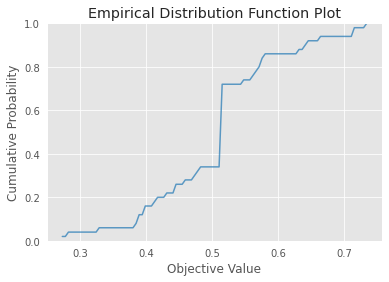

In [ ]:
#visualization
optuna.visualization.matplotlib.plot_edf([study_s])
plt.show()

Επίδοση αυτού του μοντέλου

In [ ]:
svm1 = make_pipeline(StandardScaler(), PCA(n_components = 4),\
                    SVC(C =0.146, kernel = 'rbf', gamma="auto", max_iter = 3000))
acc_s1, f1_s1, clf_s1, y_s1, time_s1 = out_box(svm1,X_train, y_train,\
                                               X_test, y_test, timer = True)
print('SVM Optimized version 1')
print(f'accuracy score: {acc_s1:.3f}')
print(f'f1 macro score: {f1_s1:.3f}')
print(f'Fit time: {time_s1:.1f} seconds')

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVM Optimized version 1
accuracy score: 0.429
f1 macro score: 0.553
Fit time: 39.6 seconds


Η σημασία των υπερπαραμέτρων φαίνεται στο παρακάτω διάγραμμα

In [ ]:
optuna.visualization.plot_param_importances(study_s)

Η παραπάνω εικόνα κάποιες φορές δεν φαίνεται. Υπάρχει στο φάκελο images.

#### Συμπεραίνουμε τα εξής:

Το μοντέλο τα πήγε πολύ χειρότερα από ότι το out_of_the_box.

Η επιλογή χαρακτηριστικών με τη χρήση Variance Threshold δεν βοήθησε. Το ίδιο και η εξισορρόπηση του συνόλου δεδομένων.

Η επιλογή του Standard Scaler βοηθάει, όπως είχαμε δει και στο out-of-the-box.

Το PCA με 4 components φαίνεται επίσης ότι βοηθάει.

Από τους πυρήνες που δοκιμάσαμε o rbf είναι ο καλύτερος. Μένει να συγκριθεί και με τον linear που δεν τον δοκιμάσαμε εδώ.

Τις παραμέτρους C και gamma θα τις εξετάσουμε περαιτέρω.

#### Με βάση αυτές τις παρατηρήσεις οργανώνουμε το εξής πείραμα

Εξετάζουμε τιμές gamma, C και kernel rbf και linear. Παρατηρούμε ότι ο πυρήνας linear υπερτερεί κατά πολύ.

Αποτελέσματα πειράματος:

| parameter  | value|  
|---------------|:-----:|
|SVM (C)|          10|
|SVM (kernel)|      linear|
|SVM (gamma)|      auto|

Επίδοση μοντέλου:

|             |         |
|-------------|:-------:|
|accuracy score| 0.981|
|f1 macro score| 0.977|
|Fit time| 14.3 seconds|

Εκτελούμε ακόμη ένα πείραμα για να μελετήσουμε την επίδραση της PCA.

Αποτελέσματα πειράματος:

| parameter  | value|  
|---------------|:-----:|
|PCA (n_components|7    |
|SVM (C)|          10|
|SVM (kernel)|      linear|
|SVM (gamma)|      auto|

Επίδοση μοντέλου:

|             |         |
|-------------|:-------:|
|accuracy score| 0.981|
|f1 macro score| 0.977|
|Fit time| 14.3 seconds|

Η επίδοση παραμένει σταθερή, ενώ αφαιρέσαμε μία διάσταση. Άρα κρατάμε την PCA.

Τώρα εκτελούμε ένα τέταρτο πείραμα γιατί παρατηρούμε ότι η παράμετρος C έπιασε την ανώτατη τιμή της. Δοκιμάζουμε και άλλες τιμές της C (μεγαλύτερες).

Αποτελέσματα πειράματος:

| parameter  | value|  
|---------------|:-----:|
|SVM (C)|          1200|

Επίδοση μοντέλου:

|             |         |
|-------------|:-------:|
|accuracy score| 0.985|
|f1 macro score| 0.980|
|Fit time| 1841.0 seconds|

Η παράμετρος C προσδιορίστηκε με σημαντική ακρίβεια στην τιμή 1200 (από 10 που ήταν στο προηγούμενο πείραμα).

Κώδικας στο Παράρτημα


Η επίδοση παραμένει η ίδια με προηγουμένως, παρόλο που μειώσαμε κατά ένα τη διάσταση (7 συνιστώσες PCA αντί για 8). Θα δοκιμάσουμε και την βελτίωση του C, επειδή επιλέχθηκε το άνω όριο των επιλογών του.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  


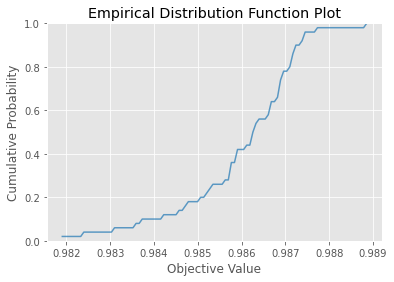

In [ ]:
study4 = optuna_search4.study_
optuna.visualization.matplotlib.plot_edf([study4])
plt.show()

Από την παρακάτω γραφική φαίνεται ότι η βέλτιστη τιμή της C βρίσκεται κάπου ανάμεσα στο 1000 και το 1500 (η επίδοση πέφτει). Θα μπορούσαμε να βρούμε την τιμή της με μεγαλύτερη ακρίβεια αλλά όπως φαίνεται από την παραπάνω γραφική η διαφορά στην επίδοση θα ήταν αμελητέα (3ο δεκαδικό ψηφίο).

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.



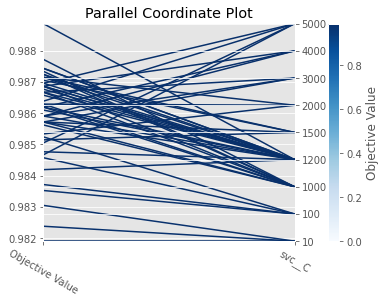

In [ ]:
study4 = optuna_search4.study_
optuna.visualization.matplotlib.plot_parallel_coordinate(study4)
plt.show()

Το καλύτερο μοντέλο SVM που βρήκαμε:

In [ ]:
svm5 = make_pipeline(StandardScaler(), PCA(n_components = 7),\
                    SVC(C =1200))
acc_s5, f1_s5, clf_s5, y_s5, time_s5 = out_box(svm5,X_train, y_train,\
                                               X_test, y_test, timer = True)
print('SVM Optimized version 5')
print(f'accuracy score: {acc_s5:.3f}')
print(f'f1 macro score: {f1_s5:.3f}')
print(f'Fit time: {time_s5:.1f} seconds')

SVM Optimized version 5
accuracy score: 0.986
f1 macro score: 0.981
Fit time: 60.0 seconds


#### Σύγκριση μοντέλων SVM

| SVM version   | Acc |    F1|
|---------------|:-----:|-----------:|
| out-of-the-box|  0.975 |       0.973 |
| optimized v1|  0.429 |       0.553 |
| optimized v2|  0.981 |       0.977 |
| optimized v5 |  0.986 |       0.981 |

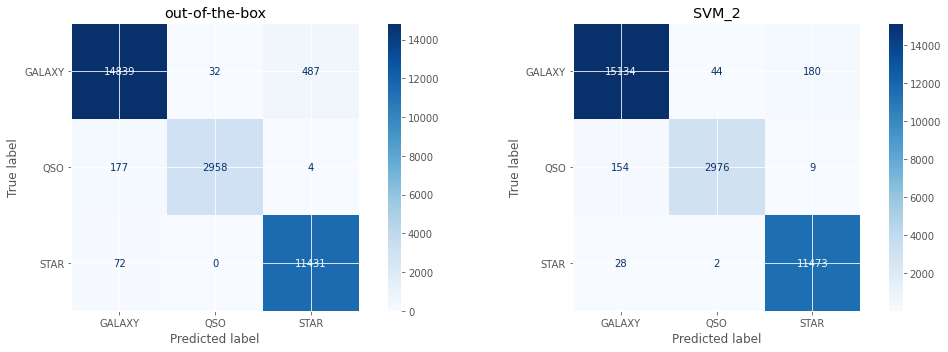

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
#predictions = [y_df, y_ds, y_s, y_m]
models = [clf_s, clf_s5]
clfs = ['out-of-the-box', 'SVM_2','SVM_5']
#for y_pred, ax, clf in zip(predictions, axes.flatten(), clfs):
    #ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
for model, ax, clf in zip(models, axes.flatten(), clfs):
    plot_confusion_matrix(model, 
                              X_test, 
                              y_test, 
                              ax=ax, 
                              cmap='Blues')
    ax.title.set_text(clf)
    plt.tight_layout()  
plt.show()

#### Βελτιστοποίηση Ταξινομητή MLP

Επαναλαμβάνουμε τα ίδια βήματα με SVM

Τα αποτελέσματα του πειράματος:

| parameter  | value|  
|---------------|:-----:|
| VarianceThreshold (variance)|  0.0 |    
| Scaler|  StandardScaler|
|Balanced |       False |
|PCA (n_components) | 8|
|MLP (hidden_layer)|  (100,150)|
|MLP (activation)|     tanh|
|MLP (solver)|      Adam|

In [ ]:
path_m = 'best_mlp.pickle'
file = open('../input/pickles-optuna/'+ path_m, 'rb')
study_m = pickle.load(file)
file.close()
#print(study_m.best_trials)
print(study_m.best_params)
print(study_m.best_value)

{'variance': '0', 'scaler': 'StandardScaler', 'balanced': False, 'n_components': 8, 'n_layers': 2, 'n_units_0': 100, 'n_units_1': 150, 'activation': 'tanh', 'solver': 'adam', 'tol': 0.0006038882283830192, 'early_stopping': True, 'n_iter_no_change': 20, 'max_iter': 60}
0.9881714285714287


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


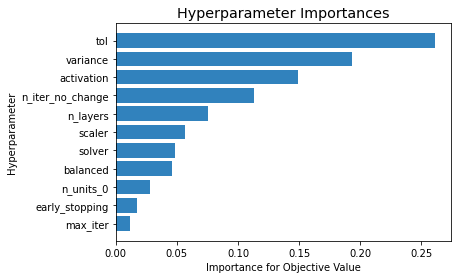

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study_m)
plt.show()

In [ ]:
mlp1 = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes = (100,150),\
                                                     activation='tanh',\
                                                     tol = 0.0006,early_stopping = True,\
                                                    n_iter_no_change= 20, max_iter= 60\
                                                    ))
acc_m1, f1_m1, clf_m1, y_m1, time_m1 = out_box(mlp1,X_train, y_train,\
                                               X_test, y_test, timer = True)
print('MLP Optimized version 1')
print(f'accuracy score: {acc_m1:.3f}')
print(f'f1 macro score: {f1_m1:.3f}')
print(f'Fit time: {time_m1:.1f} seconds')

MLP Optimized version 1
accuracy score: 0.987
f1 macro score: 0.984
Fit time: 62.6 seconds


Ήδη το MLP έχει πολύ ανταγωνιστική επίδοση, οπότε δεν συνεχίζουμε την βελτιστοποίηση. Θα απορρίψουμε το PCA επειδή με 8 συνιστώσες (όσες και τα χαρακτηριστικά δηλαδή) δεν θα μας βοηθήσει στην μείωση της διαστατικότητας.

Αν θέλαμε να κάνουμε ακόμη πιο εξαντλητική βελτιστοποίηση θα εξετάζαμε τον αριθμό των νευρώνων στα κρυφά επίπεδα, ακόμη και τον αριθμό των κρυφών επιπέδων, αλλά κάτι τέτοιο ξεφεύγει των στόχων της εργασίας.

#### Σύγκριση μοντέλων MLP

| MLP version   | Acc |    F1|
|---------------|:-----:|-----------:|
| out-of-the-box|  0.981 |       0.973 |
| MLP v1|  0.987|       0.984 |

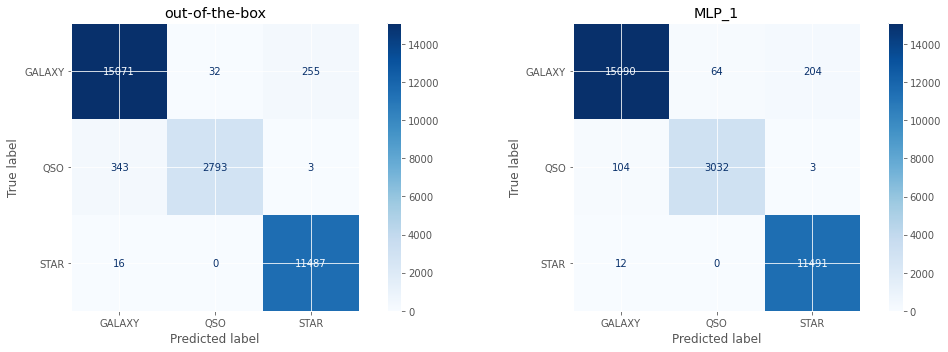

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
#predictions = [y_df, y_ds, y_s, y_m]
models = [clf_m, clf_m1]
clfs = ['out-of-the-box', 'MLP_1']
#for y_pred, ax, clf in zip(predictions, axes.flatten(), clfs):
    #ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
for model, ax, clf in zip(models, axes.flatten(), clfs):
    plot_confusion_matrix(model, 
                              X_test, 
                              y_test, 
                              ax=ax, 
                              cmap='Blues')
    ax.title.set_text(clf)
    plt.tight_layout()  
plt.show()

#### Ταξινομητής Custom MLP για σύγκριση

Για να συγκρίνουμε τα αποτελέσματα του MLP της scikit-learn και να έχουμε ένα ισχυρό Baseline, όσο βρισκόμασταν ακόμη στην αρχή των προσπαθειών μας, φτιάξαμε το δικό μας MLP μέσω της βιβλιοθήκης Pytorch. Ο κώδικας δίνεται στο παράρτημα.

Τα αποτελέσματα του πειράματος:

| parameter  | value|  
|---------------|:-----:|
| VarianceThreshold (variance)|  0.0 |    
| Scaler|  StandardScaler|
|Balanced |       False |
|PCA (n_components) | 8|
|MLP (hidden_layer)|  (150,100)|
|MLP (activation)|     sigmoid|

In [ ]:
path_cm = 'best_c_mlp.pickle'
file = open('../input/pickles-optuna/'+ path_cm, 'rb')
study_cm = pickle.load(file)
file.close()

study_cm.best_params

{'variance': '0',
 'scaler': 'StandardScaler',
 'balanced': False,
 'n_components': 8,
 'n_layers': 2,
 'n_units_0': 150,
 'n_units_1': 100,
 'activation': 'sigmoid',
 'batch_size': '256',
 'hidden_layer': '128',
 'ETA': 0.000992672272416814,
 'weight_decay': 5.836399076032222e-05}

## Αποτελέσματα και Συμπεράσματα

#### Αποτελέσματα βελτιστοποιημένων ταξινομητών

#### Confusion Matrix βελτιστοποιημένων ταξινομητών

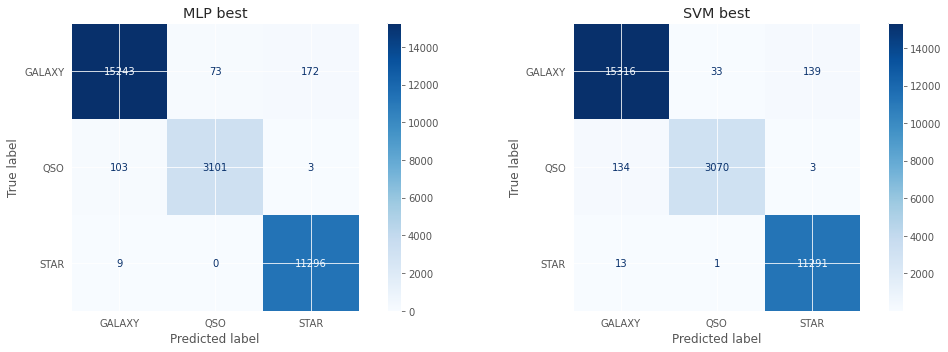

In [ ]:
from sklearn.metrics import plot_confusion_matrix
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
#predictions = [y_df, y_ds, y_s, y_m]
models = [clf_m1, clf_s5]
clfs = ['MLP best', 'SVM best']
#for y_pred, ax, clf in zip(predictions, axes.flatten(), clfs):
    #ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues')
for model, ax, clf in zip(models, axes.flatten(), clfs):
    plot_confusion_matrix(model, 
                              X_test, 
                              y_test, 
                              ax=ax, 
                              cmap='Blues')
    ax.title.set_text(clf)
    plt.tight_layout()  
plt.show()

## Τελική επιλογή ταξινομητή προβλήματος

Και οι δύο ταξινομητές έφτασαν σε πολύ καλά και σχεδόν ίδια αποτελέσματα. Δεδομένης της δυσκολίας που παρουσιάζει το SVM στην αντιμετώπιση πολλών δεδομένων αλλά και της ευελιξίας του MLP στην εκπαίδευση (μεγαλύτερη ευελιξία στην επιλογή υπερπαραμέτρων), θεωρούμε ότι το MLP είναι καλύτερη επιλογή σε ένα ρεαλιστικό πρόβλημα και πιθανόν να γενικεύει καλύτερα. Από την άλλη το MLP έχει το αρνητικό ότι μπορεί να μην έχει τόσο σταθερή απόδοση, ακριβώς λόγω αυτής της ευελιξίας. Υπάρχουν εναλλακτικές που συνδυάζουν τη σταθερότητα του SVM με την ευελιξία του MLP, όπως για παράδειγμα ο GradientBoost [scikit GB](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) που χρησιμοποιείται συχνά στο πρόβλημα αυτό στην βιβλιογραφία. 

## Βιβλιογραφία και κώδικας

Το επίσημο site του dataset:
[sdss](https://www.sdss.org/)

Για την καλύτερη κατανόηση του προβλήματος μας βοήθησαν τα δύο paper που προτείνονται στην σελίδα του dataset: 

[Thuan & Gunn](https://iopscience.iop.org/article/10.1086/129982)

[Fugukita, M et al,](https://adsabs.harvard.edu/full/1996AJ%E2%80%A6.111.1748F)

Χρήσιμη βοήθεια για την προεπεξεργασία και επισκόπηση των δεδομένων αποτέλεσαν αυτά τα δύο παραδείγματα:

[SDSS DR16 Data Analysis, Anna Pisarenko](https://www.kaggle.com/annapisarenko/sdss-dr16-data-analysis)

[space bodies classification, Francesco Pudda](https://www.kaggle.com/frank95/0-99-f1-score-space-bodies-classification)

# Παράρτημα

Επισκόπηση δεδομένων που απορρίφθηκαν

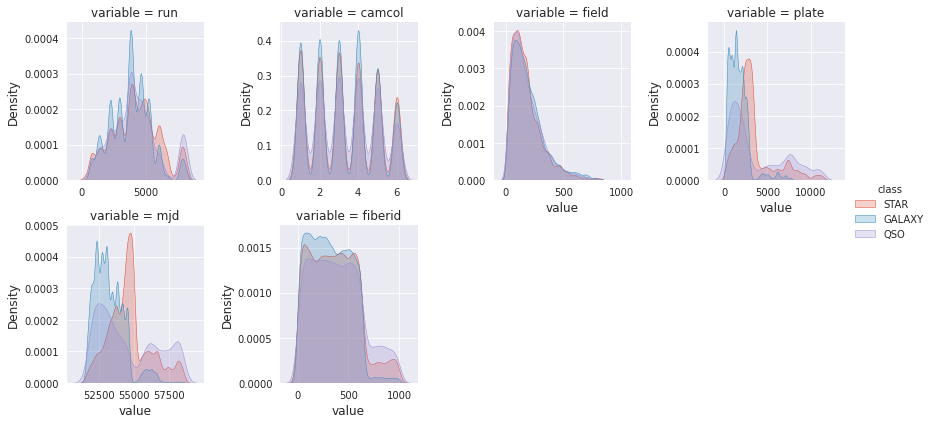

In [ ]:
melted = data_df.melt(id_vars=['class'],
                 value_vars=['run','camcol','field','plate','mjd','fiberid'])
g = sns.FacetGrid(melted, col='variable', col_wrap=4, hue='class',
                 margin_titles=True, sharex=False, sharey=False)
g = g.map(sns.kdeplot, 'value', shade=True)
g = g.add_legend()

Παρατηρούμε ότι δεν υπάρχει διαχωρισιμότητα μεταξύ των κλάσεων για τα περισσότερα από αυτά τα χαρακτηριστικά.

Σημασία του redshift

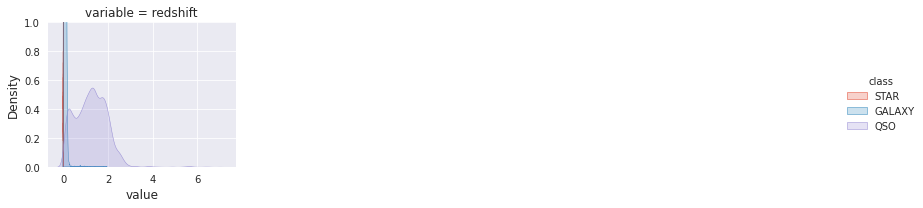

In [ ]:
sns.set_style('darkgrid')
melted = data_df.melt(id_vars = ['class'], value_vars=['redshift'])
g = sns.FacetGrid(melted, col='variable', col_wrap=4, hue = 'class',
                 margin_titles=True, sharex=False, sharey=False)
g = g.map(sns.kdeplot, 'value', shade=True)
g = g.add_legend()
g = g.set(ylim=(0, 1))

Το χαρακτηριστικό μετατόπισης προς το ερυθρό (redshift) διαχωρίζει τόσο καλά τα δεδομένα που είναι σε τελείως διαφορετική κλίμακα με αποτέλεσμα να μην φαίνονται καν στην γραφική παράσταση. 

Αυτό είναι ευνόητο από φυσικής άποψης, επειδή από το φαινόμενο Doppler τα ουράνια σώματα που βρίσκονται σε διαφορετικές αποστάσεις ως προς την γη, θα παρουσιάζουν τελείως διαφορετική μετατόπιση μήκους κύματος, λόγω της απόστασης που θα πρέπει να διανύσει το φως μέχρι να φτάσει στον φακό στην γη. Δηλαδή, τα μακρινά σώματα φαίνονται πιο κόκκινα από ότι τα κοντινά σώματα. 

Αυτό ακριβώς συμβαίνει στην περίπτωση των κλάσεων που μας απασχολούν εδώ επειδή συνήθως σώματα της ίδιας κλάσης εντοπίζονται σε παρόμοιες αποστάσεις, οι οποίες είναι σε τελείως διαφορετική κλίμακα μεταξύ κλάσεων (τα αστέρια που εντοπίζουν οι ερευνητές βρίσκονται σε κοντινές αποστάσεις ως προς τη γη, με μικρή μετατόπιση προς το ερυθρό, ενώ τα κβάζαρ βρίσκονται σε πολύ μακρινές αποστάσεις από τη γη, συνήθως, με μεγάλη μετατόπιση προς το ερυθρό).

Πειράματα βελτιστοποίησης SVM

SVM linear

In [ ]:
'''
#N is the sample size we use according to our ratio and our 70.000 full sample size
clf = make_pipeline(StandardScaler(), SVC())
CrossValidation = StratifiedShuffleSplit(n_splits=10, test_size = int(N*0.3), train_size = int(N*0.7))
param_distributions = {"svc__gamma": optuna.distributions.CategoricalDistribution(('auto', 'scale')),
                       "svc__C": optuna.distributions.CategoricalDistribution((0.1, 1, 10)), 
                       "svc__kernel": optuna.distributions.CategoricalDistribution(("linear", "rbf"))}   
optuna_search = optuna.integration.OptunaSearchCV(clf, param_distributions, cv=CrossValidation, n_trials = 10)

acc_s2, f1_s2, optuna_search2, y_s2, time_s2 = out_box(optuna_search, X_small, y_small, X_test, y_test, timer = True)

print(optuna_search2.best_params_)

print('SVM Optimized version 2')
print(f'accuracy score: {acc_s2:.3f}')
print(f'f1 macro score: {f1_s2:.3f}')
print(f'Fit time: {time_s2:.1f} seconds')
'''
''

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  import sys
[I 2021-12-03 15:47:00,379] A new study created in memory with name: no-name-65905040-c876-4bf7-a4d0-4d4c7c882ad7
[I 2021-12-03 15:47:01,448] Trial 0 finished with value: 0.968095238095238 and parameters: {'svc__gamma': 'auto', 'svc__C': 10, 'svc__kernel': 'rbf'}. Best is trial 0 with value: 0.968095238095238.
[I 2021-12-03 15:47:02,399] Trial 1 finished with value: 0.970095238095238 and parameters: {'svc__gamma': 'auto', 'svc__C': 1, 'svc__kernel': 'linear'}. Best is trial 1 with value: 0.970095238095238.
[I 2021-12-03 15:47:04,832] Trial 2 finished with value: 0.9805714285714286 and parameters: {'svc__gamma': 'auto', 'svc__C': 10, 'svc__kernel': 'linear'}. Best is trial 2 with value: 0.9805714285714286.
[I 2021-12-03 15:47:05,893] Trial 3 finished with value: 0.9700000000000001 and parameters

{'svc__gamma': 'auto', 'svc__C': 10, 'svc__kernel': 'linear'}
SVM Optimized version 2
accuracy score: 0.981
f1 macro score: 0.977
Fit time: 14.3 seconds


SVM PCA

In [ ]:
'''
#N is the sample size we use according to our ratio and our 70.000 full sample size
clf = make_pipeline(StandardScaler(), PCA(), SVC())
CrossValidation = StratifiedShuffleSplit(n_splits=10, test_size = int(N*0.3), train_size = int(N*0.7))
param_distributions = {"pca__n_components": optuna.distributions.CategoricalDistribution((4,5,6,7)),
                       "svc__gamma": optuna.distributions.CategoricalDistribution(('auto', 'scale')),
                       "svc__C": optuna.distributions.CategoricalDistribution((0.1, 1, 10)), 
                       "svc__kernel": optuna.distributions.CategoricalDistribution(("linear", "rbf"))}   
optuna_search = optuna.integration.OptunaSearchCV(clf, param_distributions, cv=CrossValidation, n_trials = 50)

acc_s3, f1_s3, optuna_search3, y_s3, time_s3 = out_box(optuna_search, X_small, y_small, X_test, y_test, timer = True)

print(optuna_search3.best_params_)

print('SVM Optimized version 3')
print(f'accuracy score: {acc_s3:.3f}')
print(f'f1 macro score: {f1_s3:.3f}')
print(f'Fit time: {time_s3:.1f} seconds')
'''
''

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  
[I 2021-12-03 15:52:50,697] A new study created in memory with name: no-name-dc9a209a-3125-43db-8905-3e8a159597e7
[I 2021-12-03 15:52:52,433] Trial 0 finished with value: 0.9633333333333335 and parameters: {'pca__n_components': 6, 'svc__gamma': 'auto', 'svc__C': 10, 'svc__kernel': 'rbf'}. Best is trial 0 with value: 0.9633333333333335.
[I 2021-12-03 15:52:54,325] Trial 1 finished with value: 0.9243809523809524 and parameters: {'pca__n_components': 6, 'svc__gamma': 'auto', 'svc__C': 1, 'svc__kernel': 'rbf'}. Best is trial 0 with value: 0.9633333333333335.
[I 2021-12-03 15:52:57,211] Trial 2 finished with value: 0.9827619047619048 and parameters: {'pca__n_components': 7, 'svc__gamma': 'auto', 'svc__C': 10, 'svc__kernel': 'linear'}. Best is trial 2 with value: 0.9827619047619048.
[I 2021-12-03 15:52:59,002]

{'pca__n_components': 7, 'svc__gamma': 'auto', 'svc__C': 10, 'svc__kernel': 'linear'}
SVM Optimized version 3
accuracy score: 0.981
f1 macro score: 0.977
Fit time: 126.5 seconds


SVM parameter C

In [ ]:
'''
#N is the sample size we use according to our ratio and our 70.000 full sample size
clf = make_pipeline(StandardScaler(), PCA(n_components = 7), SVC(kernel = 'linear', gamma = 'auto'))
CrossValidation = StratifiedShuffleSplit(n_splits=10, test_size = int(N*0.3), train_size = int(N*0.7))
param_distributions = {"svc__C": optuna.distributions.CategoricalDistribution((10, 100, 1000, 1200, 1500, 2000, 3000, 4000, 5000)), 
                      }   
optuna_search = optuna.integration.OptunaSearchCV(clf, param_distributions, cv=CrossValidation, n_trials = 50)

acc_s4, f1_s4, optuna_search4, y_s4, time_s4 = out_box(optuna_search, X_small, y_small, X_test, y_test, timer = True)

print(optuna_search4.best_params_)

print('SVM Optimized version 4')
print(f'accuracy score: {acc_s4:.3f}')
print(f'f1 macro score: {f1_s4:.3f}')
print(f'Fit time: {time_s4:.1f} seconds')
'''
''

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  
[I 2021-12-03 16:07:36,196] A new study created in memory with name: no-name-6ac97274-457e-4749-bd20-537381ad029b
[I 2021-12-03 16:09:08,147] Trial 0 finished with value: 0.986952380952381 and parameters: {'svc__C': 5000}. Best is trial 0 with value: 0.986952380952381.
[I 2021-12-03 16:09:42,206] Trial 1 finished with value: 0.9856190476190477 and parameters: {'svc__C': 1000}. Best is trial 0 with value: 0.986952380952381.
[I 2021-12-03 16:10:09,898] Trial 2 finished with value: 0.987238095238095 and parameters: {'svc__C': 1000}. Best is trial 2 with value: 0.987238095238095.
[I 2021-12-03 16:10:33,902] Trial 3 finished with value: 0.9862857142857143 and parameters: {'svc__C': 1000}. Best is trial 2 with value: 0.987238095238095.
[I 2021-12-03 16:10:41,895] Trial 4 finished with value: 0.9845714285714285

{'svc__C': 1200}
SVM Optimized version 4
accuracy score: 0.985
f1 macro score: 0.980
Fit time: 1841.0 seconds


Custom MLP κώδικας

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

import copy

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CenteringApplier(object):
    """
    class which mean-centers and makes std=1
    """
    def __init__(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.array(list(map(lambda j : 1e-3 if j == 0 else j, np.std(X, axis=0))))
        
    def __call__(self, datum):
        if len(datum) == 2:
            x, y = datum[0], datum[1]
            return (x - self.mean)/ self.std, y
        else:
            x = datum
            return (x - self.mean)/ self.std

class DigitData(Dataset):

    def __init__(self, X, Y, transform=None):
        self.transform = transform
#         tens = torch.tensor
        self.data = list(zip(X,Y)) if Y is not None else X

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        datum = self.data[idx]
        return self.transform(datum) if self.transform else datum

class LinearWActivation(nn.Module):

    def __init__(self, in_features, out_features, activation):
        super(LinearWActivation,self).__init__()
        self.f = nn.Linear(in_features,out_features, dtype=torch.float64)  #in_features = input_dimension
        if activation == 'relu':
              self.a = nn.ReLU()
        if activation == 'sigmoid':
              self.a = nn.Sigmoid()
        if activation == 'logsigmoid':
              self.a = nn.LogSigmoid()
        if activation == 'tanh':
              self.a = nn.Tanh()

    def forward(self,x):
        return self.a(self.f(x))

class MyPredictionNet(nn.Module):

    def __init__(self, layers, n_features, h_features, n_classes, activation):
        super(MyPredictionNet, self).__init__()
        layers_in = [n_features] + layers
        layers_out = layers + [h_features]
        self.f = nn.Sequential(
            *[LinearWActivation(in_feats, out_feats, activation) 
             for in_feats, out_feats in zip(layers_in,layers_out)])
        self.clf = nn.Linear(h_features, n_classes, dtype=torch.float64)

    def forward(self, x):
        return self.clf(self.f(x))
        #return self.f(x)

           
class PytorchNNModel(nn.Module, BaseEstimator, ClassifierMixin):
    def __init__(self, kwargs):
        super(PytorchNNModel, self).__init__()
        self.kwargs = kwargs
        self.__dict__.update(self.kwargs)  
        self.model = MyPredictionNet(self.layers, self.n_features, self.hidden_layer, self.n_classes, self.activation)   #input and output dimension == n_classes
        self.criterion = nn.CrossEntropyLoss() 
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.ETA, weight_decay=self.weight_decay)
        print(f"The network architecture is: \n {self.model}")

    def fit(self, X, y):
#         tr_dataset = DigitData(X, y, CenteringApplier(X))
        tr_dataset = DigitData(X, y)

        l = len(tr_dataset)
        train_split, val_split = int(.8*l), l-int(.8*l)
        train_dataset, val_dataset = torch.utils.data.random_split(tr_dataset, (train_split, val_split))

        train_dl = DataLoader(train_dataset, batch_size=self.batch_sz, shuffle=True)
        val_dl = DataLoader(val_dataset, batch_size=self.batch_sz, shuffle=True)
        error = []
        for epoch in range(self.epochs): # loop through dataset
            self.model.train() # gradients "on"  
            for i, data in enumerate(train_dl): # loop through batches
                X_batch, Y_batch = data # get the features and labels
                self.optimizer.zero_grad() # ALWAYS USE THIS!! 
                out = self.model(X_batch) # forward pass
                loss = self.criterion(out, Y_batch) # compute per batch loss 
                loss.backward() # compurte gradients based on the loss function
                self.optimizer.step() # update weights


            self.model.eval() # turns off batchnorm/dropout 
            running_average_loss = 0
            with torch.no_grad(): # no gradients required!! eval mode, speeds up computation
                for i, data in enumerate(val_dl):
                    X_batch, Y_batch = data # test data and labels
                    out = self.model(X_batch) # get net's predictions
                    loss = self.criterion(out, Y_batch) # compute per batch loss 
            running_average_loss += loss.detach().item()
            # print("Epoch error: {} \t Epoch: {}".format(running_average_loss, epoch))
            if epoch == 0:
                error.append(running_average_loss)
                error.append(copy.deepcopy(self.model))
                error.append(epoch)
            if error[0] > running_average_loss:
                error[0] = running_average_loss
                error[1] = copy.deepcopy(self.model)
                error[2] = epoch

        self.best_model = copy.deepcopy(error[1])
        print("Less error: {} \t Epoch: {}".format(error[0], error[2]))
        return self
    
    def predict(self, X):
#         test_dataset = DigitData(X, None, CenteringApplier(X))        
        test_dataset = DigitData(X, None)     

        test_dl = DataLoader(test_dataset, batch_size=self.batch_sz)
        
        # switch to eval mode
        # disable regularization layers, such as Dropout
        self.best_model.eval()
#         running_loss = 0.0

        y_pred = []  # the predicted labels

        # obtain the model's device ID
        device = next(self.best_model.parameters()).device

        #  in evaluation mode, we don't want to keep the gradients
        # so we do everything under torch.no_grad()
        with torch.no_grad():
            for index, batch in enumerate(test_dl, 1):
                # get the inputs (batch)
                inputs = batch

                inputs = inputs.to(device)

                outputs = self.best_model(inputs) 

                # We compute the loss only for inspection (compare train/test loss)
                # because we do not actually backpropagate in test time

#                 loss = self.criterion(outputs, labels)  

                #  make predictions (class = argmax of posteriors)

                _, pred = outputs.max(1) # argmax since output is a prob distribution  

                y_pred += list(pred) 
#                 running_loss += loss.data.item()
                
#         print(f"Test Loss:{running_loss}")
        return y_pred

    def score(self, X, y):
        # Return accuracy score.
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

def evaluate_nn_classifier(X, y, kwargs, folds=5):
    """ Create a pytorch nn classifier and evaluate it using cross-validation
    Calls evaluate_classifier
    """
#     print(kwargs) 
    return cross_val_score(PytorchNNModel(kwargs), X, y, cv=KFold(n_splits=folds), scoring="accuracy")  # calculate  k-fold-cross-validation 
    
    ## Preprocessing for making instance of CustomMLP ##
    le = LabelEncoder()
    le.fit(y_train)
    y_train = le.transform(y_train) # update label in train set
    y_test = le.transform(y_test) # update label in test set
    n_classes = le.classes_.size # the number of the total labels
    hidden_layer = 128
    n_features = X_train.shape[1]
    layers = [] #1-hidden layer
    EPOCHS = 30 # more epochs means more training on the given data. IS this good ?? 60
    BATCH_SZ = 128
    ETA = 1e-2 
    weight_decay = 1e-7
    activation = 'relu'
    
    ## Initialize parameters for CustomMLP ##
    kwargs = {
        'batch_sz': BATCH_SZ,
        'epochs': EPOCHS,
        'layers': layers,
        'n_features': n_features,
        'hidden_layer': hidden_layer,
        'n_classes': n_classes,
        'ETA': ETA,
        'weight_decay': weight_decay,
        'activation': activation
    }

In [ ]:
def print_stats():
    global X_train, y_train, X_test, y_test, data_df, X, y

    ## Preprocessing for making instance of CustomMLP ##
    le = LabelEncoder()
    le.fit(y_train)
    y_train = le.transform(y_train) # update label in train set
    y_test = le.transform(y_test) # update label in test set
    n_classes = le.classes_.size # the number of the total labels
    hidden_layer = 128
    n_features = X_train.shape[1]
    layers = [] #1-hidden layer
    EPOCHS = 30 # more epochs means more training on the given data. IS this good ?? 60
    BATCH_SZ = 128
    ETA = 1e-2 
    weight_decay = 1e-7
    activation = 'relu'
    ## Initialize parameters for CustomMLP ##
    kwargs = {
        'batch_sz': BATCH_SZ,
        'epochs': EPOCHS,
        'layers': layers,
        'n_features': n_features,
        'hidden_layer': hidden_layer,
        'n_classes': n_classes,
        'ETA': ETA,
        'weight_decay': weight_decay,
        'activation': activation
    }

    ## Store our models ##
    models = [
                DummyClassifier(strategy="most_frequent"), 
                DummyClassifier(strategy="stratified"),
                SVC(),
                MLPClassifier(max_iter=EPOCHS),
                PytorchNNModel(kwargs)
              ]

    ## Store our models' name ##
    clfs = ['DC-mf', 'DC-str', 'SVM','MLP','CustomMLP']
    acc = []
    f1 = []
    prec = []
    rec = []
    folds = 10
    ratio = 0.1
    dim = X_train.shape[0]
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

    for model, ax, clf in zip(models, axes.flatten(), clfs):

        ## For the SVM, we use only 10% of the dataset, because of the big amount of time ##  
        X_tr_samples = X_tr_small if clf == 'SVM' else X_train
        y_tr_samples = y_tr_small if clf == 'SVM' else y_train
        X_ts_samples = X_ts_small if clf == 'SVM' else X_test
        y_ts_samples = y_ts_small if clf == 'SVM' else y_test

        ## Cross Validation Score ###
        cv_acc = cross_val_score(model, X_tr_samples, y_tr_samples, cv=KFold(n_splits=folds), scoring="accuracy")

        ### Fit model to get the predictions ###
        model.fit(X_tr_samples, y_tr_samples)
        model_preds = model.predict(X_ts_samples)

        temp1 = classification_report(y_ts_samples, model_preds, output_dict=True)

        acc.append(np.mean(cv_acc))
        f1.append(temp1['macro avg']['f1-score'])
        prec.append(temp1['macro avg']['precision'])
        rec.append(temp1['macro avg']['recall'])

        plot_confusion_matrix(model, 
                              X_ts_samples, 
                              y_ts_samples, 
                              ax=ax, 
                              cmap='Blues')
        ax.title.set_text(clf)
        plt.tight_layout()  

    return list(zip(clfs, acc, f1, prec, rec))